# Vehicle Detection and Tracking

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Useful functions from the course

The great thing about this project was that most of the code was already provided and explained in the lessons. Most of the code works as it is and the only challenging part is tuning the various parameters.
The only change I made is in the find_cars function where instead of drawing rectangles on the image I am returning the list of bounding boxes similar to search_windows method so that we can add heat and apply thresholds to these bounding boxes as well.
I use search_windows for searching for cars in individual images. But find_cars is used for the processing pipeline for videos.

### Import Statements

In [1]:
import cv2
import os
import glob
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
from collections import deque

%matplotlib inline

### Utility Functions

In [2]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'BGR2RGB':
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if conv == 'RGB2BGR':
        return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### HOG Feature Extraction

In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

### Feature Extraction Functions

In [4]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

### Window Functions

In [5]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = convert_color(draw_img, conv='RGB2YCrCb')
    img = img.astype(np.float32)/255.0
    
    ctrans_tosearch = img[ystart:ystop,:,:]
    # ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    on_windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                on_windows.append(((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
                
    return on_windows

## Dataset Exploration

These datasets are comprised of images taken from the GTI vehicle image database, the KITTI vision benchmark suite, and examples extracted from the project video itself. Here I am creating a list of all the png files for vehicles and non-vehicles and printing some statistics. Note that the actual images will be parsed in the extract_features method. Here I am providing some sample car and not-car images.

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


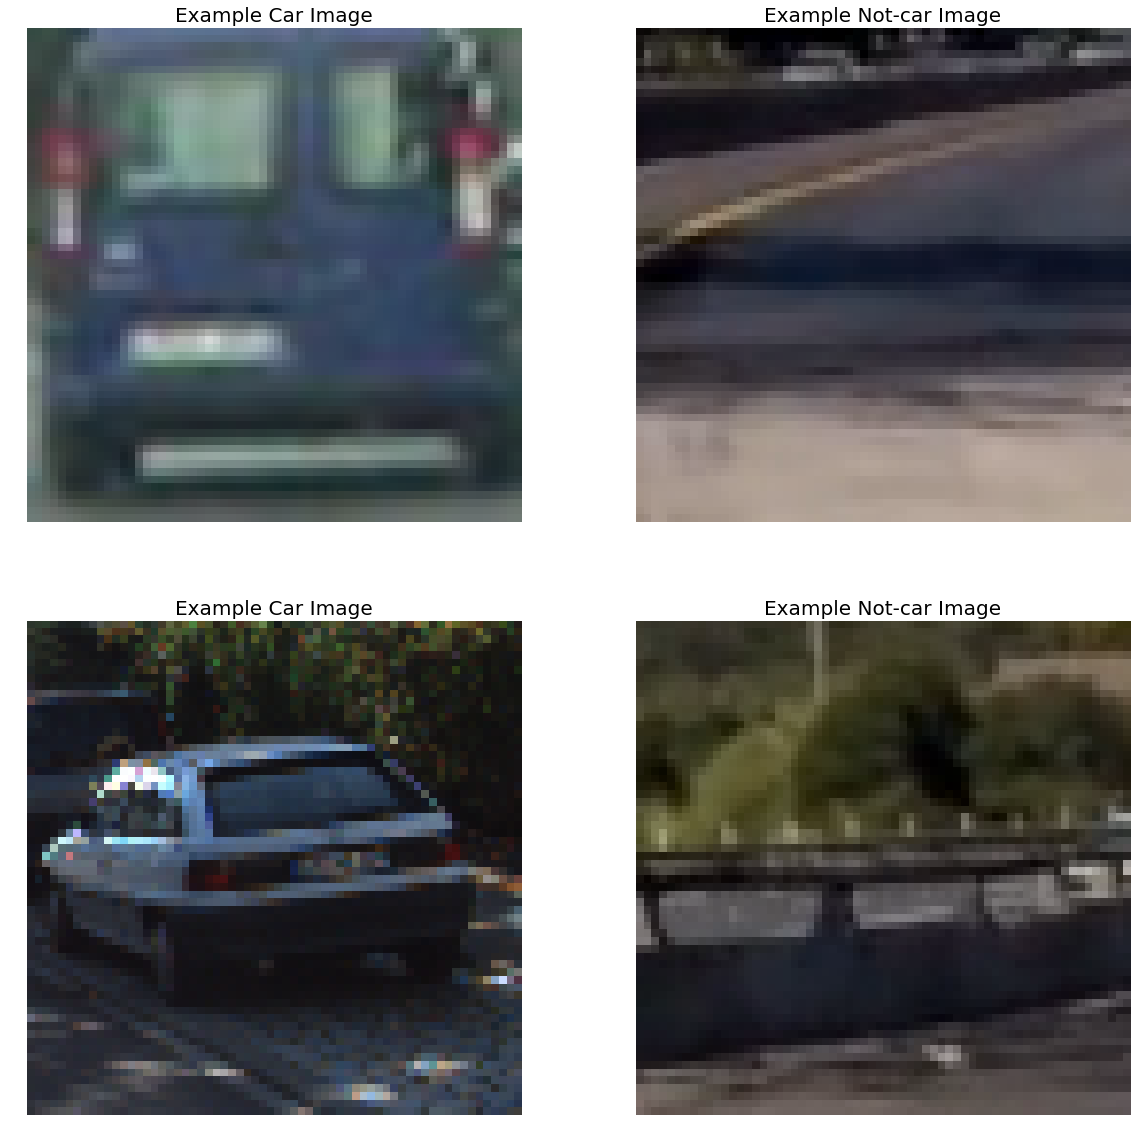

In [6]:
not_car_images = glob.glob('./non-vehicles/***/*.png', recursive = True)
car_images = glob.glob('./vehicles/***/*.png', recursive = True)
cars = []
notcars = []

for image in not_car_images:
    notcars.append(image)
    
for image in car_images:
    cars.append(image)
        
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

fig, axs = plt.subplots(2, 2, figsize=(20,20))
axs = axs.ravel()
for i in range(2):
    axs[2*i].axis('off')
    axs[2*i].imshow(mpimg.imread(cars[np.random.randint(0, len(cars))]))
    axs[2*i].set_title('Example Car Image', fontsize=20)
    axs[2*i+1].axis('off')
    axs[2*i+1].imshow(mpimg.imread(notcars[np.random.randint(0, len(notcars))]))
    axs[2*i+1].set_title('Example Not-car Image', fontsize=20)

## HOG Visualization
I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using the `YCrCb` color space and HOG parameters of `orientations=9`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:


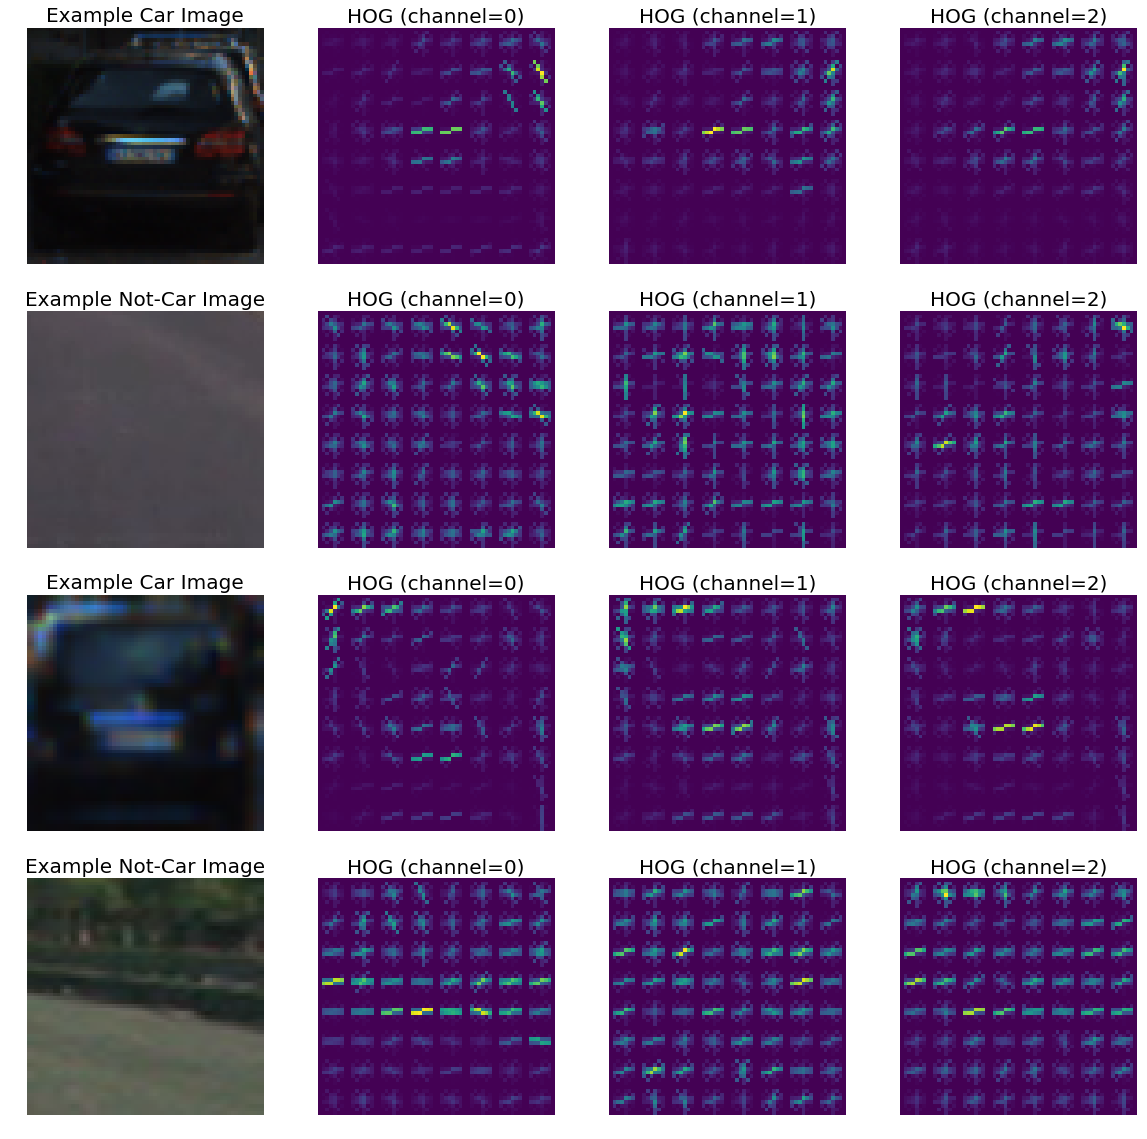

In [7]:
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

def hog_image(image, channel=0):
    yrcb = convert_color(image)
    features, hog_image = get_hog_features(yrcb[:,:,channel], orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)
    return hog_image

fig, axs = plt.subplots(4, 4, figsize=(20,20))
axs = axs.ravel()

for i in range(2):
    car_image = mpimg.imread(cars[np.random.randint(0, len(cars))])
    notcar_image = mpimg.imread(notcars[np.random.randint(0, len(notcars))])
    axs[8*i].axis('off')
    axs[8*i].imshow(car_image)
    axs[8*i].set_title('Example Car Image', fontsize=20)
    for j in range(3):
        axs[8*i+j+1].axis('off')
        axs[8*i+j+1].imshow(hog_image(car_image, channel=j))
        axs[8*i+j+1].set_title('HOG (channel=' + str(j) + ')', fontsize=20)
    axs[8*i+4].axis('off')
    axs[8*i+4].imshow(notcar_image)
    axs[8*i+4].set_title('Example Not-Car Image', fontsize=20)
    for j in range(3):
        axs[8*i+j+5].axis('off')
        axs[8*i+j+5].imshow(hog_image(notcar_image, channel=j))
        axs[8*i+j+5].set_title('HOG (channel=' + str(j) + ')', fontsize=20)

### Training a Classifier
I used the extract_features methdo from the lessons as is. Since the image dataset was small, I decided to use all the three types of features (HOG, histogram and spatial). I also decided to use the YCrCb colorspace because it was giving the best results. For spatial and histogram features I used the default parammeters because they were already tweaked in the lessons.
For HOG I chose ALL hog channels with 9 orientations. This is because selecting a single hog channel was not working for the classifier. I used a Linear SVM which is known to work well for HOG features. I scaled the features using StandardScaler and split 20% of data randomly into a test set. The statistics of he whole process are printed below:

In [8]:
### Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 600]

t1 = time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2 - t1, 2), 'seconds to extract car features...')
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t3 = time.time()
print(round(t3 - t2, 2), 'seconds to extract non-car features...')
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

t4 = time.time()
print(round(t4 - t3, 2), 'seconds to scale/transform features...')
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t5 = time.time()
svc.fit(X_train, y_train)
t6 = time.time()
print(round(t6 - t5, 2), 'seconds to train Linear SVM...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

49.05 seconds to extract car features...
50.92 seconds to extract non-car features...
6.36 seconds to scale/transform features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
31.16 seconds to train Linear SVM...
Test Accuracy of SVC =  0.9904


## Processing sample images

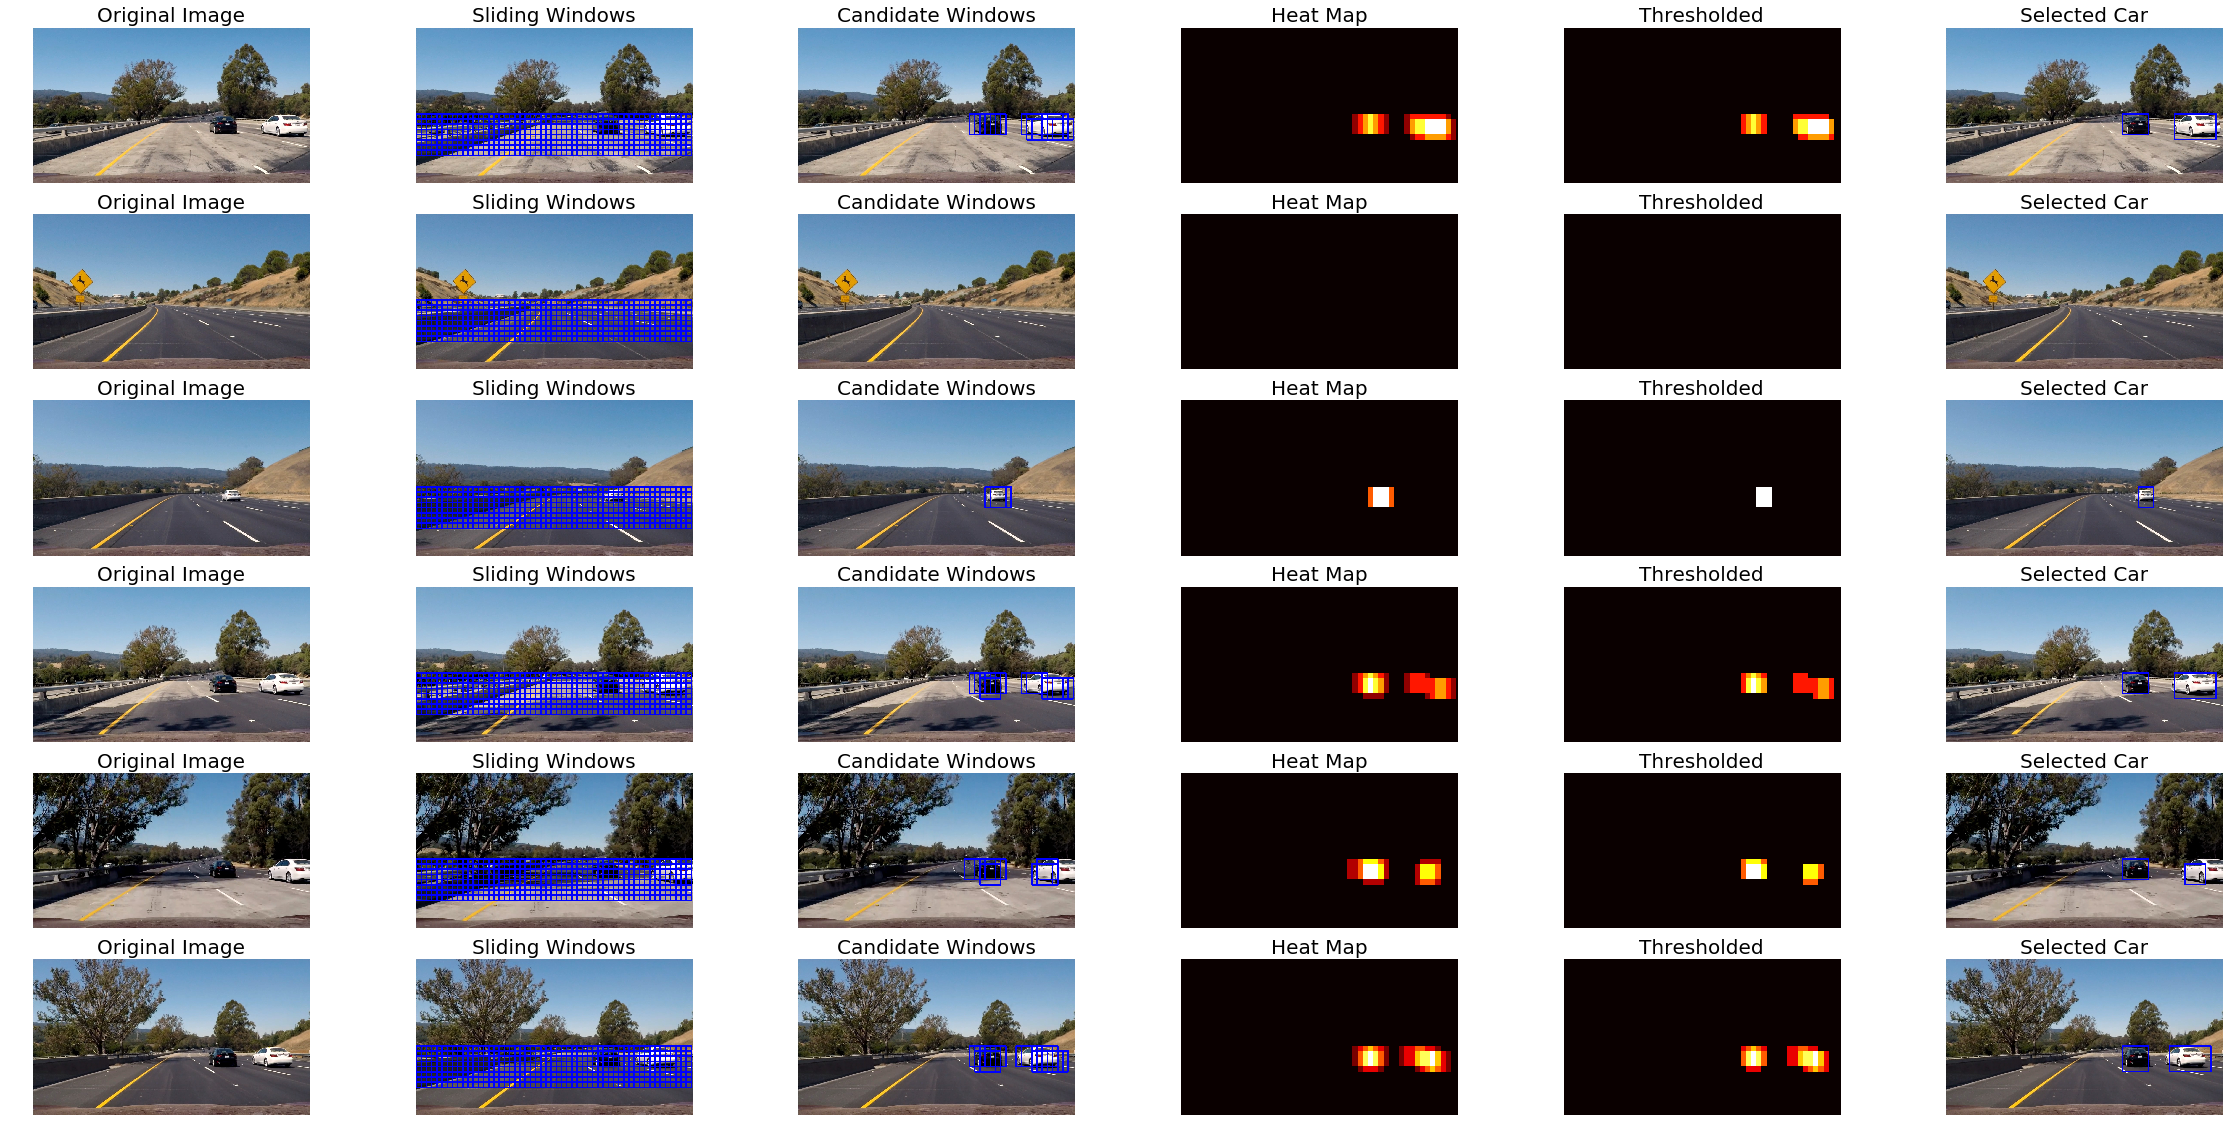

In [9]:
fig, axs = plt.subplots(6, 6, figsize=(40,20))
axs = axs.ravel()
images = glob.glob('test_images/*.jpg')
for idx, fname in enumerate(images):
    target_file = fname.split(os.sep)[-1]
    image = mpimg.imread(fname)
    draw_image = np.copy(image)
    axs[6*idx].axis('off')
    axs[6*idx].imshow(draw_image)
    axs[6*idx].set_title('Original Image', fontsize=20)
    
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255.0
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    window1_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)                    
    axs[6*idx+1].axis('off')
    axs[6*idx+1].imshow(window1_img)
    axs[6*idx+1].set_title('Sliding Windows', fontsize=20)
    plt.imsave('output_images/sliding-windows/' + target_file, window1_img)
    
    box_list = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window2_img = draw_boxes(draw_image, box_list, color=(0, 0, 255), thick=6)                    
    axs[6*idx+2].axis('off')
    axs[6*idx+2].imshow(window2_img)
    axs[6*idx+2].set_title('Candidate Windows', fontsize=20)
    plt.imsave('output_images/candidate-windows/' + target_file, window2_img)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, box_list)
    axs[6*idx+3].axis('off')
    axs[6*idx+3].imshow(heat, cmap='hot')
    axs[6*idx+3].set_title('Heat Map', fontsize=20)
    plt.imsave('output_images/heat-map/' + target_file, heat, cmap='hot')

    heat = apply_threshold(heat, 1)
    heatmap = np.clip(heat, 0, 255)
    axs[6*idx+4].axis('off')
    axs[6*idx+4].imshow(heatmap, cmap='hot')
    axs[6*idx+4].set_title('Thresholded', fontsize=20)

    labels = label(heatmap)
    result = draw_labeled_bboxes(draw_image, labels)
    axs[6*idx+5].axis('off')
    axs[6*idx+5].imshow(result)
    axs[6*idx+5].set_title('Selected Car', fontsize=20)
    plt.imsave('output_images/detected-cars/' + target_file, result)

## Video Pipeline

The code below implements a pipeline for video processing. It takes the approach introduced in Project 1 (Finding Lane Lines).
A queue of 30 frames is kept to eliminate false positives that do not appear in more than a given threshold of frames.

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# a queue of 30 frames to detect false positives
heat_maps = deque([], 30)
frame_threshold = 1

def apply_threshold_to_frames():
    frames = np.array(list(heat_maps))
    heat = np.sum(frames, axis=0)
    heat = apply_threshold(heat, frame_threshold)
    return heat

def process_image(image):
    box_list = find_cars(image, y_start_stop[0], y_start_stop[1], 1.5, svc, 
                              X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, box_list)
    heat_maps.append(heat)
    heat = apply_threshold_to_frames()
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    result = draw_labeled_bboxes(np.copy(image), labels)

    return result

For the test video, the frame threshold for eliminating false positives is 1 because its a small video.

In [11]:
frame_threshold = 1
heat_maps.clear()

test_output = 'output_videos/test_video.mp4'
clip1 = VideoFileClip("./test_video.mp4")
test_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video output_videos/test_video.mp4
[MoviePy] Writing video output_videos/test_video.mp4


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 38/39 [00:31<00:00,  1.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_video.mp4 

Wall time: 33.9 s


Here's the video output.

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

For project video, the frame threshod is 15. i.e. Any detection that lasts less than 15 frames is eliminated as a false positive.

In [13]:
frame_threshold = 15
heat_maps.clear()

project_output = 'output_videos/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [15:11<00:00,  1.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 15min 12s


Here's the video output.

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

## Summary
Keras is a great tool to use if you want to quickly build a neural network and evaluate performance.